In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import pluq
import pluq.aminoacids
from io import StringIO
#import pynmrstar
from collections import defaultdict
#import seaborn as sns
import nmrglue as ng 
#from descartes import PolygonPatch
#from lmfit import Model
import itertools
from io import StringIO
from pluq.base import Correlation
from pluq.fileio import read_region
import scipy

sns.set_context('paper')
sns.set_palette('colorblind')
plt.rcParams['svg.fonttype'] = 'none'

domain_colors = ['purple', '#fc8d62', '#66c2a5']

ModuleNotFoundError: No module named 'fiona'

In [15]:
!pip3 install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.9 MB/s eta 0:00:00
  Using cached uncertainties-3.1.7-py2.py3-none-any.whl (98 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 16.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492022 sha256=0c1063daab011c01924afc24753482145495e7abc67a31d2045d00a5365ce84b
  Stored in directory: /Users/yunyao_1/Library/Caches/pip/wheels/5e/a9/47/f118e66afd12240e4662752cc22cefae5d97275623aa8ef57d
Successfully built future

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [10]:
import os
import sys
path = os.path.abspath(os.path.join('/opt/homebrew/lib/python3.11/site-packages/pluq-0.2.1-py3.11.egg'))
if path not in sys.path:
    sys.path.append(path)

In [2]:
seq=''' GHMASMEMEKEFEQIDKSGS WAAIYQDIRHEASDFPCRVA KLPKNKNRNRYRDVSPFDHS RIKLHQEDNDYINASLIKME EAQRSYILTQGPLPNTCGHF WEMVWEQKSRGVVMLNRVME KGSLKCAQYWPQKEEKEMIF EDTNLKLTLISEDIKSYYTV RQLELENLTTQETREILHFH YTTWPDFGVPESPASFLNFL FKVRESGSLSPEHGPVVVHC SAGIGRSGTFCLADTCLLLM DKRKDPSSVDIKKVLLEMRK FRMGLIQTADQLRFSYLAVI EGAKFIMGDSSVQDQWKELS HEDLEPPPEHIPPPPRPPKR ILEPHNGKCREFFPNHQWVK EETQEDKDCPIKEEKGSPLN AAPYGIESMSQDTEVRSRVV GGSLRGAQAASPAKGEPS'''
seq=''.join(seq.split())
#CTD=slice(275,414)
#Q_N_rich=slice(341,368)
len(seq)

398

In [24]:
import pandas as pd

def calculate_amino_acid_percentages(sequence):
    # Dictionary to store the count of each amino acid
    amino_acid_counts = {}

    # Calculate the total number of amino acids in the sequence
    total_amino_acids = len(sequence)

    # Loop through the sequence and count each amino acid
    for amino_acid in sequence:
        amino_acid_counts[amino_acid] = amino_acid_counts.get(amino_acid, 0) + 1

    # Dictionary to store the percentage of each amino acid
    amino_acid_percentages = {}

    # Calculate the percentage of each amino acid
    for amino_acid, count in amino_acid_counts.items():
        percentage = (count / total_amino_acids) * 100
        amino_acid_percentages[amino_acid] = percentage

    return amino_acid_counts, amino_acid_percentages


if __name__ == "__main__":
    amino_acid_sequence = seq
    counts, percentages = calculate_amino_acid_percentages(amino_acid_sequence)

    # Create a Pandas DataFrame
    df = pd.DataFrame({
        "Amino Acid": list(counts.keys()),
        "Count": list(counts.values()),
        "Percentage": [round(percentage, 1) for percentage in percentages.values()]
    })

    print(df)


   Amino Acid  Count  Percentage
0           G     22         5.5
1           H     13         3.3
2           M     13         3.3
3           A     20         5.0
4           S     32         8.0
5           E     39         9.8
6           K     29         7.3
7           F     16         4.0
8           Q     18         4.5
9           I     20         5.0
10          D     21         5.3
11          W      7         1.8
12          Y     10         2.5
13          R     23         5.8
14          P     28         7.0
15          C      8         2.0
16          V     20         5.0
17          L     31         7.8
18          N     13         3.3
19          T     15         3.8


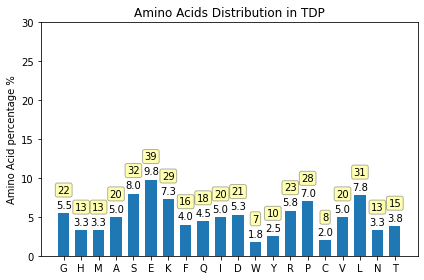

In [26]:
#plot
width=0.65
x=np.arange(len(df['Amino Acid']))
fig, ax = plt.subplots()
labels=df['Amino Acid']
dist=ax.bar(x, df['Percentage'], width)
ax.set_ylabel('Amino Acid percentage %')
ax.set_title('Amino Acids Distribution in TDP')
ax.set_xticks(x)
ax.set_ylim((0,30))
ax.set_xticklabels(labels)

def autolabel(rects,labels):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for (rect,  label) in zip(rects, labels):
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        #print(label)
        
        ax.annotate('{}'.format(label), 
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 18),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))
#rects=df['No.of_res']
autolabel(dist,df['Count'] )
fig.tight_layout()
fig.savefig('PTP1B_AA_distribution.png', format="png",dpi=1000)

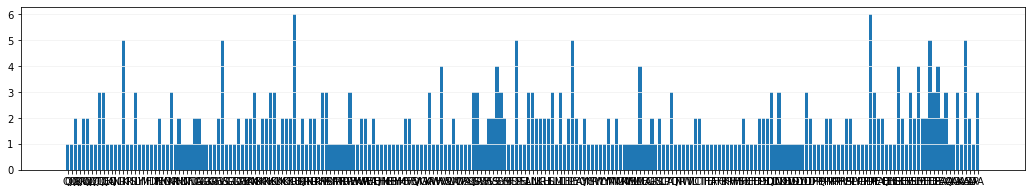

In [31]:
pair=[]
for i in range(1,len(seq)-1):
    pair.append(seq[i]+seq[i+1])
dic_pair={}
#CTD_list=list(seq)
AA_PTP1B=set(seq)
for res1 in AA_PTP1B:
    for res2 in AA_PTP1B:
        dic_pair[res1 + res2]= pair.count(res1 + res2)

def omit_by(dct, predicate=lambda x: x==0 ):
    return {k: v for k, v in dct.items() if not predicate(v)}        
#dic_pair
fig=plt.figure(figsize=(18,3))
plt.grid(axis='y', color='0.95')
plt.bar(omit_by(dic_pair).keys(),omit_by(dic_pair).values())
plt.savefig('PTP1B_AA_pair_disctribution.pdf',dpi=300)
#omit_by(dic_pair)